In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc


     |████████████████████████████████| 27.3MB 154kB/s 
     |████████████████████████████████| 3.2MB 53.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6MB 39.3MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 481kB 40.9MB/s 
     |████████████████████████████████| 890kB 46.5MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 3.2MB 33.9MB/s 
  Created wheel for pycbc: filename=PyCBC-1.17.1-cp36-cp36m-linux_x86_64.whl size=5722202 sha256=b0ef904b30e96d588c497d2047f1c2ddcf1995263f02c8d600706a6a529e8333
  Stored in directory: /root/.cache/pip/wheels/d5/ce/0d/7d344b3d84b46d626df5c0fcb08451e41f2e1415e82042409e
Successfully built pycbc
  Created wheel for lscsoft-glue: filename=lscsoft_glue-2.0.0-cp36-cp36m-linux_x86_64.whl size=414148 sha256=bbf1b4f5f39a537dee96a48137d

In [2]:
from __future__ import division

import numpy
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform


using pycbc.waveform one can generate model waveforms(with different approximation). Print all the avilable wavform models from pycbc.waveform

In [3]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants thsqat are currently available
print(td_approximants())



['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'EOBNRv2_RO

**Genarating** **Gravitational wave waveforms (Compact binary sources)** Time domain

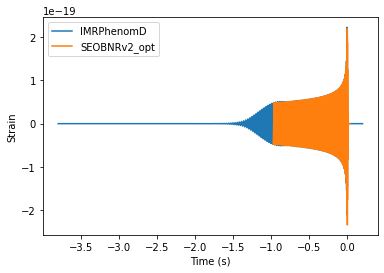

In [4]:
import pylab
from pycbc.waveform import get_td_waveform

for apx in ['IMRPhenomD', 'SEOBNRv2_opt']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=10,
                                 mass2=10,
                                 spin1z=0.9,
                                 delta_t=1.0/4096,
                                 f_lower=40)

    pylab.plot(hp.sample_times, hp, label=apx)

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')

pylab.legend()
pylab.show()


In [5]:
#in order to check the input and output of a function

help(get_td_waveform)

Help on function get_td_waveform in module pycbc.waveform.waveform:

get_td_waveform(template=None, **kwargs)
    Return the plus and cross polarizations of a time domain waveform.
    
    Parameters
    ----------
    template: object
        An object that has attached properties. This can be used to subsitute
        for keyword arguments. A common example would be a row in an xml table.
    mass1 : {None, <class 'float}
        The mass of the first component object in the binary (in solar masses).
    mass2 : {None, <class 'float}
        The mass of the second component object in the binary (in solar masses).
    spin1x : {0.0, <class 'float}
        The x component of the first binary component's dimensionless spin.
    spin1y : {0.0, <class 'float}
        The y component of the first binary component's dimensionless spin.
    spin1z : {0.0, <class 'float}
        The z component of the first binary component's dimensionless spin.
    spin2x : {0.0, <class 'float}
        The 

In [6]:
def generate_waveform(apx, m_chirp, eta, redshift, delta_t, flow, fmax):
    
    """
    Generate a waveform given a chirp mass and symmetric mass ratio
    for binaries with zero spin.
    
    m_chirp -- chirp mass in solar masses
    
    eta -- float symmetric mass ratio
    
    redshift -- float redshift value
    
    delta_f -- frequency step size in Hz
    
    flow -- minimum frequency in Hz
    
    fmax -- maximum frequency in Hz
    
    approx -- waveform approximant (i.e. 'IMRPhenomPv2','TaylorT2')
    
    both -- Boolean dictating the summation of h_plus and h_cross
    
    Returns:
    h1 -- magnitude of h_plus and h_cross in the frequency domain
    """
    
    # Generate a waveform following the same procedure in waveform_overlap.ipynb
    m1, m2 = mass1_from_mchirp_eta(m_chirp, eta), mass2_from_mchirp_eta(m_chirp, eta)
    s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.0, 0.0, 0.0
    distance = 78
    inclination_angle = 0.0
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1= m1 ,
                                 mass2=m2 ,
                                 spin1z=0.9,
                                 delta_t=1.0/4096,
                                 f_lower=flow)
    
    return hp, hc

 **Plotting GW phase and amplitude of TD waveform**

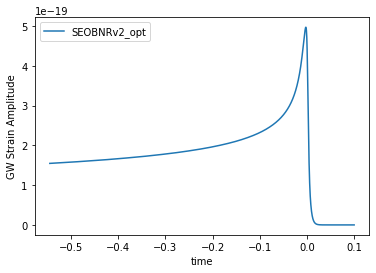

In [10]:
m_chirp, eta, redshift, delta_t, flow, fmax = 20, 0.2, 200, 1/4096.0, 30, 2000
apx = 'SEOBNRv2_opt'
hp, hc = generate_waveform(apx, m_chirp, eta, redshift, delta_t, flow, fmax)
amp = waveform.utils.amplitude_from_polarizations(hp, hc)
phase = waveform.utils.phase_from_polarizations(hp, hc)
pylab.plot(hp.sample_times, amp, label=apx)

pylab.ylabel('GW Strain Amplitude')
pylab.xlabel('time')
pylab.legend(loc='upper left')
pylab.show()


# **Accessing LIGO and VIRGO data stream** 




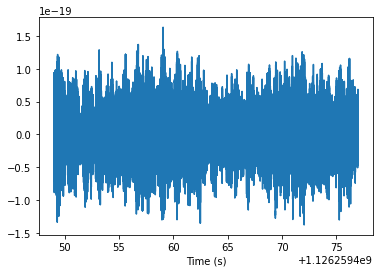

In [11]:
# As an example we use the GW150914 data
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

# As an example we use the GW150914 data
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = merger.strain(ifo)
    # Remove the low frequency content and downsample the data to 2048Hz
    strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
    #remove the begining and ending spikes from the data
    strain[ifo] = strain[ifo].crop(2, 2)
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

#print (strain.delta_t)
pylab.plot(strain['L1'].sample_times, strain['L1'])
pylab.xlabel('Time (s)')
pylab.show()



**filter wraparound**

Note the spike in the data at the boundaries. This is caused by the highpass and resampling stages filtering the data. When the filter is applied to the boundaries, it wraps around to the beginning of the data. Since the data itself has a discontinuity (i.e. it is not cyclic) the filter itself will ring off for a time up to the length of the filter.

Even if a visible transient is not seen, we want to avoid filters that act on times which are not causally connect. To avoid this we trim the ends of the data sufficiently to ensure that they do not wraparound the input. We will enforce this requirement in all steps of our filtering.


### **calculate the power spectral density** **bold text**



### **Let's estimate the mass of the system**


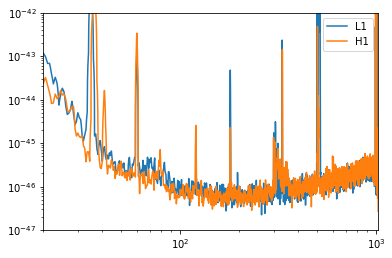

In [12]:
#first plot the power spectral density of the data
#it is important to whiten the data or in order to find the SNR
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:


    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

In [12]:
#you can print the delta_f for the psd data itself
psds[ifo].delta_f

0.03571428571428571

In [ ]:
'''
from pycbc.psd import interpolate, inverse_spectrum_truncation

psds = {}
for ifo in ['L1', 'H1']:
    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
    # We then interpolate the PSD to the desired frequency step. 
    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)

    # We explicitly control how much data will be corrupted by overwhitening the data later on
    # In this case we choose 2 seconds.
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
                                    low_frequency_cutoff=15.0,
                                    trunc_method='hann')

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()
'''

"\nfrom pycbc.psd import interpolate, inverse_spectrum_truncation\n\npsds = {}\nfor ifo in ['L1', 'H1']:\n    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate\n    # We then interpolate the PSD to the desired frequency step. \n    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)\n\n    # We explicitly control how much data will be corrupted by overwhitening the data later on\n    # In this case we choose 2 seconds.\n    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),\n                                    low_frequency_cutoff=15.0,\n                                    trunc_method='hann')\n\n    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)\n    pylab.xlim(20, 1024)\n    pylab.ylim(1e-47, 1e-42)\npylab.legend()\n"

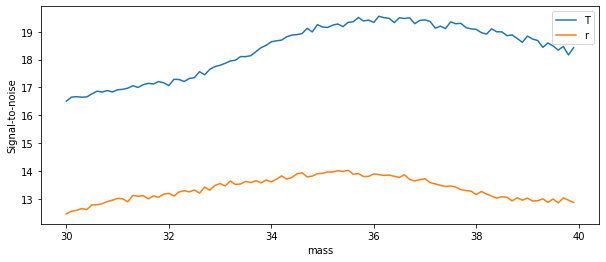

In [15]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

# We will try different component masses and see which gives us the largest 
#chirp_mass = numpy.arange(35, 37\, .1)
#masses = mass1_from_mchirp_q(chirp_mass, 1)
mass1 = numpy.arange(30, 40,0.10 ) #mass range bewteen 30 to 40 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list



ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

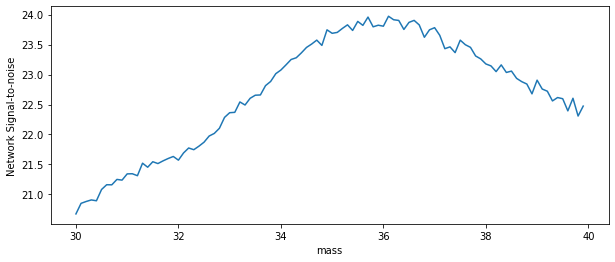

We found the best Mass1=Mass2 was 36.10 solar masses (detector frame)


In [16]:
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

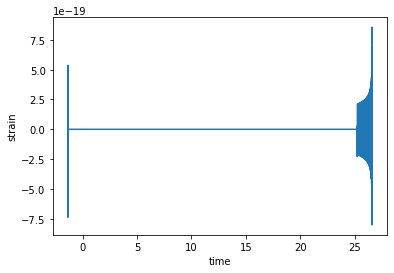

In [29]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

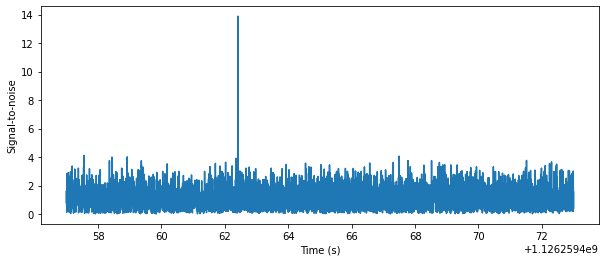

We found a signal at 1126259462.4174805s with SNR 13.881876723949462


In [31]:
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


In [32]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

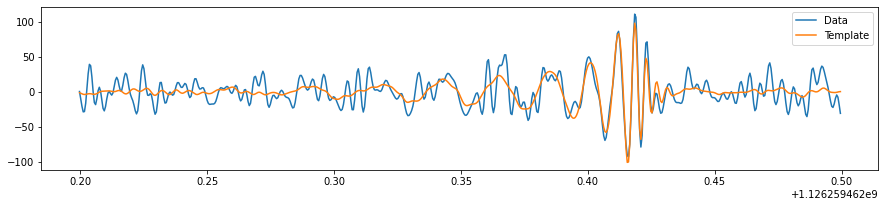

In [33]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

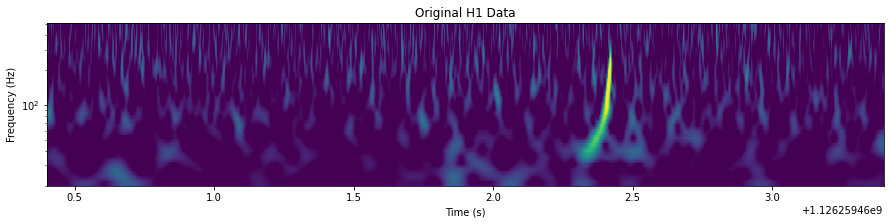

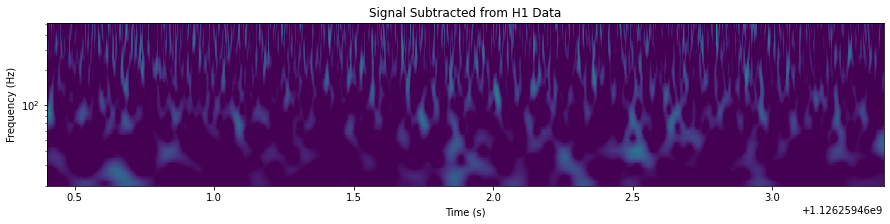

In [34]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()



Look at the pycbc.psd package to get all the model PSD of the GW detectors-

https://pycbc.org/pycbc/latest/html/pycbc.psd.html



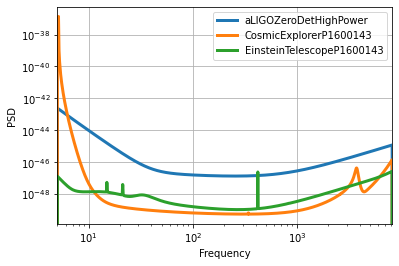

In [36]:
import pycbc.noise
import pycbc.psd
import pylab

# generate some colored gaussian noise
flow = 5.0
delta_f = 1.0 / 16
flen = int(16384.0 / (2*delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='aLIGOZeroDetHighPower')


psd = pycbc.psd.CosmicExplorerPessimisticP1600143(flen, delta_f, flow)
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='CosmicExplorerP1600143')

psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='EinsteinTelescopeP1600143')

pylab.xlim(xmin=flow, xmax=8192)
pylab.xlabel('Frequency')
pylab.ylabel('PSD')
pylab.legend()
pylab.grid()
pylab.show()

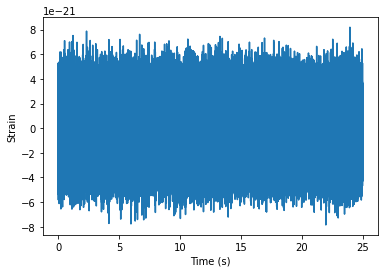

In [37]:
### Mock data generation ################

import pycbc.noise
import pycbc.psd
import pylab

# The color of the noise matches a PSD which you provide
flow = 15.0
delta_f = 1.0 / 25
flen = int(8192 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 16384.0
tsamples = int(25 / delta_t)
noise_ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

pylab.plot(noise_ts.sample_times, noise_ts)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()
